## Function to solve the subsistence problem



Last time we worked through the problem of expressing the subsistence
cost problem as a linear program, and then solving it.   That process
involved several different steps, which would be easy to get wrong.

Here we create a single function `solve_subsistence_problem`.  By
isolating the logic of constructing and solving the subsistence
problem into a stand-alone function we reduce the scope for bugs, and
this modular approach at the same time makes testing easier.

We take the different pieces of the puzzle we&rsquo;ve developed and
put them together in the form of a linear program we can solve.
Recall that the mathematical problem we&rsquo;re trying to solve is
$$
    \min_x p'x
$$
such that
$$
    \tilde{A}x \geq \tilde{b}
$$
If we buy a bag of groceries with quantities given by $x$, the total
cost of the bag of groceries is the inner product of prices and
quantities.  Since we&rsquo;ve converted our units above, this gives us a
vector of prices where quantities are all in 100 g or ml units.

The following code block defines a function
`solve_subsistence_problem`, which takes as arguments a dataframe
mapping different foods to nutrients; a series of prices for those
same foods; a series giving dietary recommended intake (DRI) minimums;
and a series giving dietary recommended maximums.



In [1]:
from  scipy.optimize import linprog as lp
import numpy as np
import warnings

def solve_subsistence_problem(FoodNutrients,Prices,dietmin,dietmax,max_weight=None,tol=1e-6):
    """Solve Stigler's Subsistence Cost Problem.

    Inputs:
       - FoodNutrients : A pd.DataFrame with rows corresponding to foods, columns to nutrients.
       - Prices : A pd.Series of prices for different foods
       - diet_min : A pd.Series of DRIs, with index corresponding to columns of FoodNutrients,
                    describing minimum intakes.
       - diet_max : A pd.Series of DRIs, with index corresponding to columns of FoodNutrients,
                    describing maximum intakes.
       - max_weight : Maximum weight (in hectograms) allowed for diet.
       - tol : Solution values smaller than this in absolute value treated as zeros.
       
    """
    try: 
        p = Prices.apply(lambda x:x.magnitude)
    except AttributeError:  # Maybe not passing in prices with units?
        warnings.warn("Prices have no units.  BE CAREFUL!  We're assuming prices are per hectogram or deciliter!")
        p = Prices

    p = p.dropna()

    # Compile list that we have both prices and nutritional info for; drop if either missing
    use = p.index.intersection(FoodNutrients.columns)
    p = p[use]

    # Drop nutritional information for foods we don't know the price of,
    # and replace missing nutrients with zeros.
    Aall = FoodNutrients[p.index].fillna(0)

    # Drop rows of A that we don't have constraints for.
    Amin = Aall.loc[Aall.index.intersection(dietmin.index)]
    Amin = Amin.reindex(dietmin.index,axis=0)
    idx = Amin.index.to_frame()
    idx['type'] = 'min'
    #Amin.index = pd.MultiIndex.from_frame(idx)
    #dietmin.index = Amin.index
    
    Amax = Aall.loc[Aall.index.intersection(dietmax.index)]
    Amax = Amax.reindex(dietmax.index,axis=0)
    idx = Amax.index.to_frame()
    idx['type'] = 'max'
    #Amax.index = pd.MultiIndex.from_frame(idx)
    #dietmax.index = Amax.index

    # Minimum requirements involve multiplying constraint by -1 to make <=.
    A = pd.concat([Amin,
                   -Amax])

    b = pd.concat([dietmin,
                   -dietmax]) # Note sign change for max constraints

    # Make sure order of p, A, b are consistent
    A = A.reindex(p.index,axis=1)
    A = A.reindex(b.index,axis=0)

    if max_weight is not None:
        # Add up weights of foods consumed
        A.loc['Hectograms'] = -1
        b.loc['Hectograms'] = -max_weight
        
    # Now solve problem!  (Note that the linear program solver we'll use assumes
    # "less-than-or-equal" constraints.  We can switch back and forth by
    # multiplying $A$ and $b$ by $-1$.)

    result = lp(p, -A, -b, method='highs')

    result.A = A
    result.b = b
    
    if result.success:
        result.diet = pd.Series(result.x,index=p.index)
    else: # No feasible solution?
        warnings.warn(result.message)
        result.diet = pd.Series(result.x,index=p.index)*np.nan  

    return result

## Setup



We take material from the earlier lecture on the subistence diet
  problem, and use it to define the subsistence diet as a function of prices. 

We need some particular versions of the following modules;



In [2]:
%pip install fooddatacentral

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install python-gnupg

Note: you may need to restart the kernel to use updated packages.


Define api key here:



In [4]:
# API key for Gov; substitute your own!
apikey = "qjmmUOQUmEiVgDOWqb5cMNWjSfLF3EzJJFtfaN1s"

## Input Data



The critical user input is a `pandas.DataFrame` with (at least)
these columns:

-   **Food:** Label used to identify food
-   **Quantity:** Amount of food
-   **Units:** Units in which amounts of this food is measured
-   **Price:** Price for quantity of food
-   **FDC:** Key identifying food in the FoodDataCentral dataset.



### Using data from Google Sheets



In [5]:
# ID of sheet and name of worksheet for google sheets.   
# Easiest if these are public (or use service accounts; share with students@eep153.iam.gserviceaccount.com)

SHEETs = [# Stigler's foods, modern prices
          ("https://docs.google.com/spreadsheets/d/11MqhRmM_NcrqkT9OVsZxmeHbHcCcle3IJSjEBT8LA_M/edit?usp=sharing","Table A"),
         ]

### Compile data on food prices



For each sheet in the list `SHEETs` grab data and concatenate into
   a DataFrame.



### Look up nutritional information for foods



Now we have a list of foods with prices.  Do lookups on USDA database
to get nutritional information.



In [7]:
import fooddatacentral as fdc
import warnings

df = pd.read_csv("data/Final Food Price Data for Both Nontraditional and Traditional - Table A.csv")

D = {}
count = 0
for food in  df.Food.tolist():
    try:
        FDC = df.loc[df.Food==food,:].FDC[count]
        count+=1
        D[food] = fdc.nutrients(apikey,FDC).Quantity
    except AttributeError: 
        warnings.warn("Couldn't find FDC Code %s for food %s." % (food,FDC))        

FoodNutrients = pd.DataFrame(D,dtype=float)

In [8]:
FoodNutrients

,Butter,Margarine,Yogurt,Cheddar Cheese,Processed Sliced Cheese,Skim Milk Powder,Soda Crackers,Spaghetti Noodles,Macaroni and Cheese Dinner,Corn Flakes,...,Pilot Biscuits,Chocolate Bars,Potato Chips,Milk 2%,UHT Milk,Apple Juice,Orange Juice,Tomato Juice,Vegetable Juice,Soft Drinks
Alanine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Alcohol, ethyl",NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Amino acids,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Arginine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vitamin K (Dihydrophylloquinone),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vitamin K (phylloquinone),NaN,NaN,NaN,2.40,3.10,NaN,NaN,NaN,NaN,NaN,...,4.40,1.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vitamins and Other Components,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Water,NaN,NaN,NaN,36.60,45.10,NaN,NaN,NaN,NaN,NaN,...,27.00,9.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Units & Prices



Now, the prices we observe can be for lots of different quantities and
units.  The FDC database basically wants everything in either hundreds
of grams (hectograms) or hundreds of milliliters (deciliters).  
We use the `units` function to convert all foods to either
deciliters or hectograms, to match FDC database:



In [9]:
# Convert food quantities to FDC units
df['FDC Quantity'] = df[['Quantity','Units']].T.apply(lambda x : fdc.units(x['Quantity'],x['Units']))

# Now may want to filter df by time or place--need to get a unique set of food names.
df['FDC Price'] = df['Price']/df['FDC Quantity']

df.dropna(how='any') # Drop food with any missing data

# To use minimum price observed
Prices = df.groupby('Food',sort=False)['FDC Price'].min()

/srv/conda/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


In [10]:
pd.options.display.max_rows=1000

In [11]:
FoodNutrients[['Carrots']]

,Carrots
Alanine,NaN
"Alcohol, ethyl",0.000
Amino acids,NaN
Arginine,NaN
Ash,NaN
Aspartic acid,NaN
Betaine,NaN
Caffeine,0.000
"Calcium, Ca",33.000
"Carbohydrate, by difference",9.580


## Dietary Requirements



We&rsquo;ve figured out some foods we can buy, the nutritional content of
those foods, and  the price of the foods.  Now we need to say
something about nutritional requirements.   Our data for this is based
on  US government recommendations available at
[https://www.dietaryguidelines.gov/sites/default/files/2021-03/Dietary_Guidelines_for_Americans-2020-2025.pdf](https://www.dietaryguidelines.gov/sites/default/files/2021-03/Dietary_Guidelines_for_Americans-2020-2025.pdf)

I&rsquo;ve put some of these data into a google spreadsheet at
[https://docs.google.com/spreadsheets/d/1y95IsQ4HKspPW3HHDtH7QMtlDA66IUsCHJLutVL-MMc/](https://docs.google.com/spreadsheets/d/1y95IsQ4HKspPW3HHDtH7QMtlDA66IUsCHJLutVL-MMc/).



In [12]:
DRIS_min = pd.read_csv("data/Dietary Requirements - diet_minimums - Dietary Requirements - diet_minimums.csv")

DRIS_max = pd.read_csv("data/Dietary Requirements - diet_maximums.csv")

# Define *minimums*

diet_min = DRIS_min.set_index('Nutrition')

# Define *maximums*
diet_max = DRIS_max.set_index('Nutrition')

## Using `solve_subsistence_problem` to analyze diet



Let&rsquo;s choose a particular group (type of person with particular
dietary requirements) and solve the subsistence problem for them:



In [13]:
group = 'F 31-50'
tol = 1e-6

result = solve_subsistence_problem(FoodNutrients,Prices,diet_min[group],diet_max[group],tol=tol)

print("Cost of diet for %s is $%4.2f per day.\n" % (group,result.fun))

# Put back into nice series
diet = result.diet

print("\nDiet (in 100s of grams or milliliters):")
print(diet[diet >= tol])  # Drop items with quantities less than precision of calculation.
print()

tab = pd.DataFrame({"Outcome":np.abs(result.A).dot(diet),"Recommendation":np.abs(result.b)})
print("\nWith the following nutritional outcomes of interest:")
print(tab)
print()

print("\nConstraining nutrients are:")
excess = tab.diff(axis=1).iloc[:,1]
print(excess.loc[np.abs(excess) < tol*100].index.tolist())

Cost of diet for F 31-50 is $11.64 per day.


Diet (in 100s of grams or milliliters):
Skim Milk Powder       0.572159
Corn Flakes            0.219819
Frozen Corn            0.824896
Apples                 1.106477
Potatoes               0.013366
Frozen French Fries    5.167458
Chocolate Bars         0.742112
dtype: float64


With the following nutritional outcomes of interest:
                                  Outcome  Recommendation
Nutrition                                                
Energy                        3100.000000          1800.0
Protein                         46.000000            46.0
Fiber, total dietary            39.364457            25.2
Folate, DFE                    912.812109           400.0
Calcium, Ca                   1237.500947          1000.0
Carbohydrate, by difference    341.934103           130.0
Iron, Fe                        18.000000            18.0
Magnesium, Mg                  320.000000           320.0
Phosphorus, P                  926.57792

## Effects of Price Changes on Subsistence Diet Cost



As prices change, we should expect the minimum cost diet to also
  change.  The code below creates a graph which changes prices away
  from the \`base&rsquo; case one food at a time, and plots changes in total
  diet cost.



In [14]:
%pip install cufflinks

Note: you may need to restart the kernel to use updated packages.


/srv/conda/lib/python3.9/site-packages/pandas/core/internals/blocks.py:937: UnitStrippedWarning:

The unit of the quantity is stripped when downcasting to ndarray.



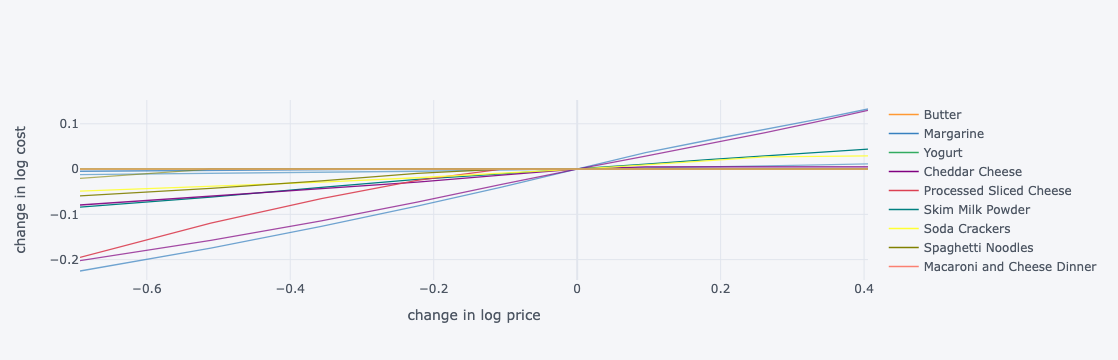

In [15]:
import cufflinks as cf
cf.go_offline()

scale = [.5,.6,.7,.8,.9,1.,1.1,1.2,1.3,1.4,1.5]

cost0 = solve_subsistence_problem(FoodNutrients,Prices,diet_min[group],diet_max[group],tol=tol).fun

Price_response={}
for s in scale:
    cost = {}
    for i,p in enumerate(Prices):
        my_p = Prices.copy()
        my_p.iloc[i] = p*s
        result = solve_subsistence_problem(FoodNutrients,my_p,diet_min[group],diet_max[group],tol=tol)
        cost[Prices.index[i]] = np.log(result.fun/cost0)
    Price_response[np.log(s)] = cost

Price_response = pd.DataFrame(Price_response).T
Price_response.iplot(xTitle='change in log price',yTitle='change in log cost')

## Effects of Price Changes on Subsistence Diet Composition



The code below creates a graph which changes prices just for *one* food,
  and traces out the effects of this change on all the foods consumed.



/srv/conda/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1990: UnitStrippedWarning:

The unit of the quantity is stripped when downcasting to ndarray.



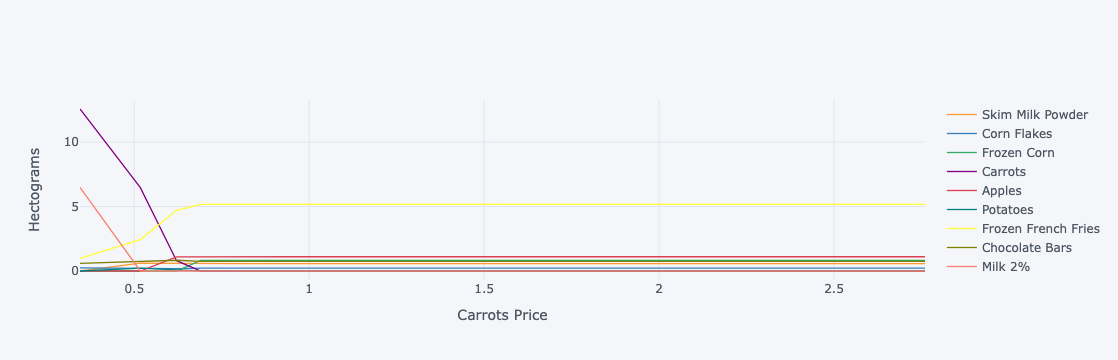

In [16]:
import cufflinks as cf
cf.go_offline()

ReferenceGood = 'Carrots'

scale = [0.5,0.75,0.9,1.,1.1,1.2,1.3,1.4,1.5,2,4]

cost0 = solve_subsistence_problem(FoodNutrients,Prices,diet_min[group],diet_max[group],tol=tol).fun

my_p = Prices.copy()

diet = {}
for s in scale:

    my_p[ReferenceGood] = Prices[ReferenceGood]*s
    result = solve_subsistence_problem(FoodNutrients,my_p,diet_min[group],diet_max[group],tol=tol)
    diet[my_p[ReferenceGood]] = result.diet

Diet_response = pd.DataFrame(diet).T
Diet_response.index.name = '%s Price' % ReferenceGood

Diet_response.reset_index(inplace=True)

# Get rid of units for index (cufflinks chokes)
Diet_response['%s Price' % ReferenceGood] = Diet_response['%s Price' % ReferenceGood].apply(lambda x: x.magnitude)

Diet_response = Diet_response.set_index('%s Price' % ReferenceGood)

# Just look at goods consumed in quantities greater than error tolerance
Diet_response.loc[:,(Diet_response>tol).sum()>0].iplot(xTitle='%s Price' % ReferenceGood,yTitle='Hectograms')

as you increase price of carrots, you consume less, and substitute with the other items, like frozen corn

## Effects of Price Changes on Subsistence Diet Nutrition



The code below creates a graph which uses the food price changes
  described above, but maps into nutrients.



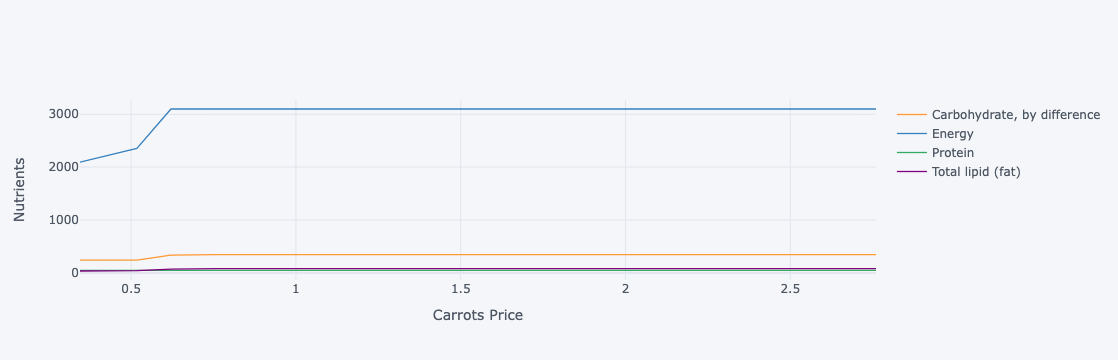

In [17]:
# Matrix product maps quantities of food into quantities of nutrients
NutrientResponse = Diet_response@FoodNutrients.T

# Drop columns of missing nutrients
NutrientResponse = NutrientResponse.loc[:,NutrientResponse.count()>0]
NutrientResponse.iplot(xTitle='%s Price' % ReferenceGood,yTitle='Nutrients')

as carrots prices  increase, you sub it with other stiff but the other stuff has different nutrietnets like energy = french fries

## Adding Constraint on Total Weight



At least at some prices the minimum cost subistence diet involves
eating unreasonable amounts of food (e.g., 10 kilograms of cabbage per
day).  We can easily add an additional constraint of the form
$$
     \sum x_i \leq \text{max weight}
$$
to our linear programming problem since it&rsquo;s just another linear
inequality, and this may give us more realistic results.



### Price Changes and Subsistence Diet Composition with Weight Constraint



Re-do our analysis of changing prices, but with a constraint that
  total weight of diet must be less that 12 hectograms (1.2 kg).



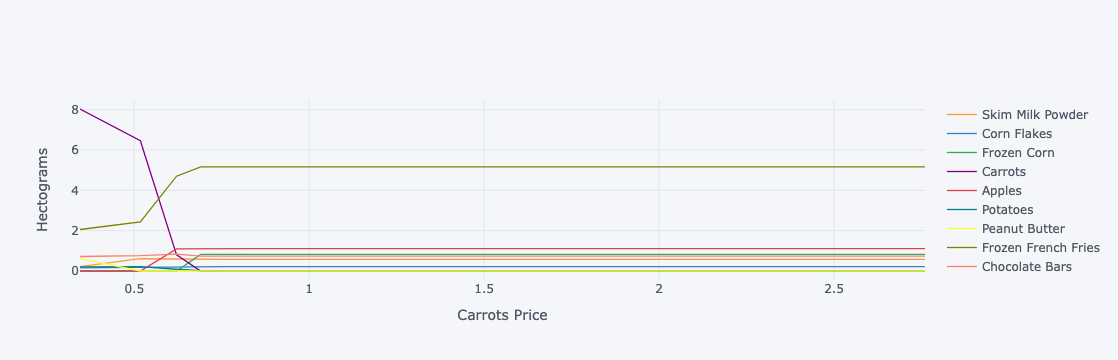

In [18]:
import cufflinks as cf
cf.go_offline()

ReferenceGood = 'Carrots'

scale = [0.5,0.75,0.9,1.,1.1,1.2,1.3,1.4,1.5,2,4]

cost0 = solve_subsistence_problem(FoodNutrients,Prices,
                                  diet_min[group],diet_max[group],max_weight=12,tol=tol).fun

my_p = Prices.copy()

diet = {}
for s in scale:

    my_p[ReferenceGood] = Prices[ReferenceGood]*s
    result = solve_subsistence_problem(FoodNutrients,my_p,
                                       diet_min[group],diet_max[group],max_weight=12,tol=tol)
    diet[my_p[ReferenceGood]] = result.diet

Diet_response = pd.DataFrame(diet).T
Diet_response.index.name = '%s Price' % ReferenceGood

Diet_response.reset_index(inplace=True)

# Get rid of units for index (cufflinks chokes)
Diet_response['%s Price' % ReferenceGood] = Diet_response['%s Price' % ReferenceGood].apply(lambda x: x.magnitude)

Diet_response = Diet_response.set_index('%s Price' % ReferenceGood)

# Just look at goods consumed in quantities greater than error tolerance
Diet_response.loc[:,(Diet_response>tol).sum()>0].iplot(xTitle='%s Price' % ReferenceGood,yTitle='Hectograms')